<h4> <font color=darkolivegreen>Necessary Functions</font> </h4>

In [201]:
#AHG exp function
def regress(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[0] #only get exp

#AHG int function
def regress2(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[1] #only get int

#bankfull hydraulics function
def calculate_bankful(df, colname, retPeriod):
    # sort data smallest to largest
    sorted_data = df.sort_values(by=colname, ascending = False)
    # count total obervations
    n = sorted_data.shape[0]
    # add a numbered column 1 -> n to use in return calculation for rank
    sorted_data.insert(0, 'rank', range(1, 1 + n))
    #find desired rank
    desiredRank = (n+1)/retPeriod
    desiredRank = round(desiredRank)
    #get variable with desired rank
    output = sorted_data.loc[sorted_data['rank'] == desiredRank, colname]
    return(output)

#AHG r2 function
def regress3(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.rsquared #only get r2

In [202]:
import pandas as pd
import os
import numpy as np
import scipy.stats.mstats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from ast import literal_eval

#set working directory
os.chdir("C:\\Users\\cbrinkerhoff\\Box Sync\\Ongoing Projects\\geomorph_class\\")

#load in barber dataset
Hydroshortened = pd.read_csv('Barber_rivers.csv', low_memory=False, encoding='latin-1')

#NHD 2.1 flowlines (with USGS gauges snapped to them) and lakes
med_NHD = pd.read_csv('NHD_med_res.csv', low_memory=False, encoding='latin-1')
med_NHD_lakes = pd.read_csv('med_NHD_lakes.csv', low_memory=False, encoding='latin-1')

#NHD sinuosity from  Wieczorek, M.E., Jackson, S.E., and Schwarz, G.E., 2018, Select Attributes for NHDPlus Version 2.1 Reach Catchments and Modified Network Routed Upstream Watersheds for the Conterminous United States: U.S. Geological Survey data release, https://doi.org/10.5066/F7765D7V. 
sinuosityCONUS = pd.read_csv('Sinuousity_CONUS.txt', delimiter=',')

Hydroshortened = pd.merge(Hydroshortened, med_NHD[['SOURCE_FEA', 'COMID', 'SLOPE', 'StreamOrde', 'ArbolateSu', 'Measure', 'LENGTHKM', 'LatSite', 'LonSite', 'FTYPE', 'FCODE', 'DASqKm', 'Tidal', 'WBAREACOMI', 'TOTMA']],left_on='site_no', right_on='SOURCE_FEA')
Hydroshortened = pd.merge(Hydroshortened, sinuosityCONUS, left_on='COMID', right_on='COMID')

In [203]:
#get depth
Hydroshortened['chan_depth'] = Hydroshortened['chan_area']/Hydroshortened['chan_width']

#cleaning NA values and hydraulics below 0 and minimum 20 measurements
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'Poor']
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'POOR']

Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notna()]

#convert needed units to metric
Hydroshortened['chan_width'] = Hydroshortened['chan_width']*0.305
Hydroshortened['chan_depth'] = Hydroshortened['chan_depth']*0.305
Hydroshortened['chan_velocity'] = Hydroshortened['chan_velocity']*0.305
Hydroshortened['chan_discharge'] = Hydroshortened['chan_discharge']*0.028

Hydroshortened['n'] = ((Hydroshortened['chan_depth'])**(2/3)*Hydroshortened['SLOPE']**(1/2))/Hydroshortened['chan_velocity']
Hydroshortened['shearStress'] = 9.81*Hydroshortened['chan_depth']*Hydroshortened['SLOPE']
Hydroshortened['Fb'] = Hydroshortened['chan_velocity']/((Hydroshortened['chan_depth']*9.81)**(1/2))
Hydroshortened['minEntrain'] = 11*Hydroshortened['chan_depth']*Hydroshortened['SLOPE']

#A0- median not minimum
Hydroshortened = Hydroshortened.join(Hydroshortened.groupby('site_no')['chan_area'].agg(['median']), on='site_no')
Hydroshortened = Hydroshortened.rename(columns={"median": "A0"})

#AHG parameters
b_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_width', ['chan_discharge']).to_frame()
a_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_width', ['chan_discharge']).to_frame()
f_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_depth', ['chan_discharge']).to_frame()
c_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_depth', ['chan_discharge']).to_frame()
m_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_velocity', ['chan_discharge']).to_frame()
k_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_velocity', ['chan_discharge']).to_frame()

b_temp = b_temp.rename(columns={0:'b'})
Hydroshortened =  pd.merge(Hydroshortened, b_temp, on='site_no')

a_temp = a_temp.rename(columns={0:'loga'})
Hydroshortened =  pd.merge(Hydroshortened, a_temp, on='site_no')

c_temp = c_temp.rename(columns={0:'logc'})
Hydroshortened =  pd.merge(Hydroshortened, c_temp, on='site_no')

f_temp = f_temp.rename(columns={0:'f'})
Hydroshortened =  pd.merge(Hydroshortened, f_temp, on='site_no')

k_temp = k_temp.rename(columns={0:'logk'})
Hydroshortened =  pd.merge(Hydroshortened, k_temp, on='site_no')

m_temp = m_temp.rename(columns={0:'m'})
Hydroshortened =  pd.merge(Hydroshortened, m_temp, on='site_no')

#Calculate some more variables
Hydroshortened['r'] = Hydroshortened['f']/Hydroshortened['b']
Hydroshortened['unitPower'] = (998*9.8*Hydroshortened['chan_discharge']*Hydroshortened['SLOPE'])/Hydroshortened['chan_width']
Hydroshortened['DistDwnstrm'] = Hydroshortened['ArbolateSu']-((Hydroshortened['Measure']/100)*Hydroshortened['LENGTHKM'])
Hydroshortened['chan_material'] = np.where(Hydroshortened['chan_material'] == 'silt', 'SILT', Hydroshortened['chan_material'])
Hydroshortened['chan_material_index'] = np.where(Hydroshortened['chan_material'] == 'BLDR', 1,
                                                np.where(Hydroshortened['chan_material'] == 'GRVL', 2,
                                                        np.where(Hydroshortened['chan_material'] == 'SAND', 3,
                                                                np.where(Hydroshortened['chan_material'] == 'SILT', 4,
                                                                        np.where(Hydroshortened['chan_material'] == 'UNSP', 5,5)))))

Hydroshortened['FCODEnorm'] = np.where(Hydroshortened['FCODE'] == 33400, 1, #connectors or canals
                                                np.where(Hydroshortened['FCODE'] == 33600, 1, #connectors or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 2, #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 3, #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 4,3))))) #lake if also in lakes dataset, otherwise its a main stem river or tidal reach and can be reclassified as perrenial river (basically....)

Hydroshortened['FTYPE'] = np.where(Hydroshortened['FCODE'] == 33400, 'ArtificalChannel', #connector or canal
                                                np.where(Hydroshortened['FCODE'] == 33600, 'ArtificalChannel', #connector or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 'IntermittentRiver', #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 'PerennialRiver', #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 'Lake/Reservoir/Wetland','PerennialRiver')))))

#Bankfull hydraulics Using 2 yr return period
bank_width = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_width', 2).to_frame()
bank_width = bank_width.rename(columns={'chan_width':'bank_width'})
Hydroshortened =  pd.merge(Hydroshortened, bank_width, on='site_no')

bank_depth = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_depth', 2).to_frame()
bank_depth = bank_depth.rename(columns={'chan_depth':'bank_depth'})
Hydroshortened =  pd.merge(Hydroshortened, bank_depth, on='site_no')

bank_Q = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_discharge', 2).to_frame()
bank_Q = bank_Q.rename(columns={'chan_discharge':'bank_Q'})
Hydroshortened =  pd.merge(Hydroshortened, bank_Q, on='site_no')

In [204]:
#Filter for impossible hydraulic geometry
Hydroshortened = Hydroshortened[Hydroshortened['b'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['b'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['f'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['f'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['m'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['m'] < 1]

In [205]:
#Filter for at least 20 measurements
groupSize = Hydroshortened.groupby('site_no').size().to_frame()
groupSize = groupSize.rename(columns={0:'groupSize'})
Hydroshortened = Hydroshortened.merge(groupSize, on='site_no')

Hydroshortened = Hydroshortened[Hydroshortened['groupSize'] >= 20]

In [206]:
#width AMHG
bySite = Hydroshortened.groupby('site_no').mean()
logWc_temp = Hydroshortened.groupby('river_name').apply(regress2, 'loga', ['b']).to_frame()
logWc_temp = logWc_temp.rename(columns={0: "logQc_w"})
logQc_w_temp = Hydroshortened.groupby('river_name').apply(regress, 'loga', ['b']).to_frame()*-1
logQc_w_temp = logQc_w_temp.rename(columns={0: "logWc"})
amhg_r2 = Hydroshortened.groupby('river_name').apply(regress3, 'loga', ['b']).to_frame()
amhg_r2 = amhg_r2.rename(columns={0:'amhg_r2'})
Hydroshortened =  pd.merge(Hydroshortened, logWc_temp, on='river_name')
Hydroshortened =  pd.merge(Hydroshortened, logQc_w_temp, on='river_name')
Hydroshortened =  pd.merge(Hydroshortened, amhg_r2, on='river_name')

In [595]:
print('\033[1m' + "# measurements:")
display(len(Hydroshortened.index))

print('\033[1m' + "# cross-sections:")

display(Hydroshortened.groupby('site_no').ngroups)

print('\033[1m' + "# rivers:")
display(Hydroshortened.groupby('river_name').ngroups)

#Hydroshortened.to_csv('for_dbscan.csv')

# measurements:


371667

# cross-sections:


1409

# rivers:


190

<h4> <font color=darkolivegreen>Map of Training Stations</font> </h4>

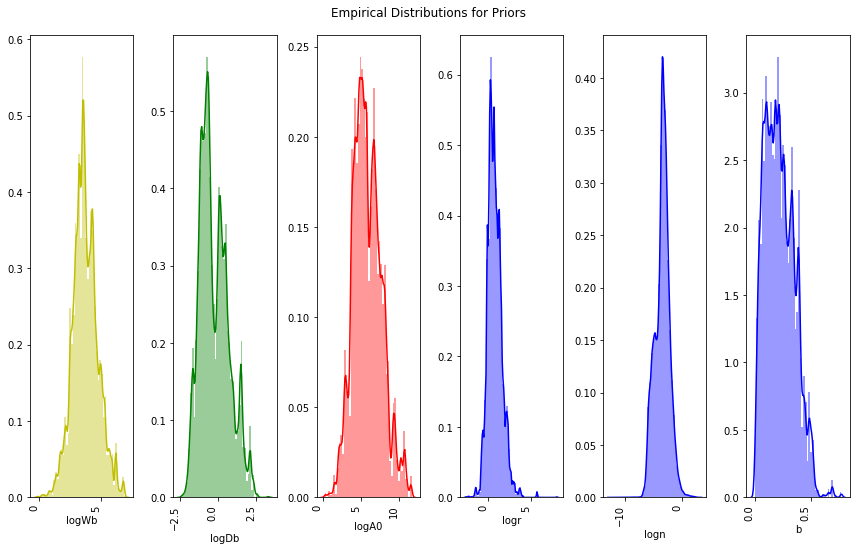

In [208]:
Hydroshortened['logA0'] = np.log(Hydroshortened['A0'])
Hydroshortened['logr'] = np.log(Hydroshortened['r'])
Hydroshortened['logn'] = np.log(Hydroshortened['n'])
Hydroshortened['logWb'] = np.log(Hydroshortened['bank_width'])
Hydroshortened['logDb'] = np.log(Hydroshortened['bank_depth'])
Hydroshortened['logQb'] = np.log(Hydroshortened['bank_Q'])
Hydroshortened['logQ'] = np.log(Hydroshortened['chan_discharge'])

Hydroshortened['log10De'] = np.log10(Hydroshortened['minEntrain'])

fig, axs = plt.subplots(ncols=6, figsize=(12, 8))
sns.distplot(Hydroshortened['logWb'], ax=axs[0], color='y')
sns.distplot(Hydroshortened['logDb'], ax=axs[1], color='g')
sns.distplot(Hydroshortened['logA0'], ax=axs[2], color='r')
sns.distplot(Hydroshortened['logr'], ax=axs[3], color='b')
sns.distplot(Hydroshortened['logn'], ax=axs[4], color='b')
sns.distplot(Hydroshortened['b'], ax=axs[5], color='b')

fig.suptitle("Empirical Distributions for Priors")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#save prior PDFs (no river type subsetting)
priorWb = Hydroshortened['logWb'].describe()
priorDb = Hydroshortened['logDb'].describe()
prior_r = Hydroshortened['logr'].describe()
priorDe = Hydroshortened['log10De'].describe()
priorQb = Hydroshortened['logQb'].describe()
priorA0 = Hydroshortened['logA0'].describe()
priorN = Hydroshortened['logn'].describe()
priorB = Hydroshortened['b'].describe()

#priorWb.to_csv('priorsWb.csv')
#priorDb.to_csv('priorsDb.csv')
#prior_r.to_csv('priorsr.csv')
#priorDe.to_csv('priorsDe.csv')
#priorQb.to_csv('priorsQb.csv')
#priorA0.to_csv('priorsA0.csv')
#priorN.to_csv('priorsN.csv')
#priorB.to_csv('priorsB.csv')

<h4> <font color=darkolivegreen>Calculate Global Hat Functions</font> </h4>

<h2> <font color=darkolivegreen>Expert Classification </font></h2>

PCA is ran on stage-invaraint features, the medians of stage-variant features, and the variances of stage-variant features at 1,409 stations
<br><br>
All told, this yields 24 predictors

In [640]:
#reduce to stations, using mean and var of obsereved hydraulics at-a-station

station_medians = Hydroshortened.groupby('site_no').median() #get average hydraulics for each station
station_medians = station_medians[['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA', 'sinuosity', 'logA0', 'logn', 'b', 'logr', 'logDb', 'logWb']]
station_var = Hydroshortened.groupby('site_no').var() #get average hydraulics for each station
station_var = station_var[['chan_velocity', 'chan_depth', 'chan_width', 'n', 'unitPower', 'Fb', 'shearStress', 'minEntrain']]

station_var.columns = ['velocity_var','depth_var','width_var',
                     'n_var','unitPower_var','Fb_var',
                      'shearStress_var', 'minEntrain_var']

pca_df = station_medians.merge(station_var, on='site_no')
pca_df

#for DBSCAN later
dbscan_df = pca_df

In [641]:
#run PCA
features = ['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 
            'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA', 'sinuosity', 'velocity_var',
            'depth_var','width_var', 'n_var','unitPower_var','Fb_var','shearStress_var', 'minEntrain_var']
x = pca_df.loc[:, features].values # Separating out the features
#y = temp.loc[:,['site_no']].values # Separating out the target
x = StandardScaler().fit_transform(x) # normalizing the features

pca = PCA(n_components=3) #ran using 5 PCs
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = pca.components_
             , columns = ['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 
            'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA', 'sinuosity', 'velocity_var',
            'depth_var','width_var', 'n_var','unitPower_var','Fb_var','shearStress_var', 'minEntrain_var'])

,0,1,2
chan_width,0.020612,0.449775,-0.060491
n,0.283657,-0.013854,-0.057696
SLOPE,0.326711,-0.050378,0.021752
StreamOrde,0.034240,0.406142,0.034349
DistDwnstrm,0.046203,0.435189,0.035897
FCODEnorm,-0.073919,0.117427,-0.054102
chan_depth,0.068257,0.423103,-0.124790
chan_velocity,0.008647,0.272547,0.266181
unitPower,0.347851,-0.027668,0.014022
r,-0.001385,-0.008047,0.005691


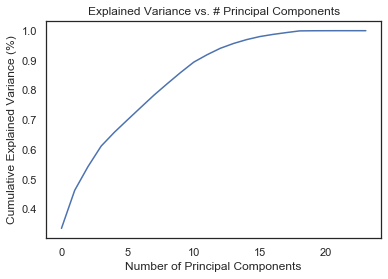

In [643]:
#Plot PCA results
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance vs. # Principal Components')

principalDf.transpose()
#pca.explained_variance_ratio_[0:8]

<h4> <font color=darkolivegreen>PCA Results </font> </h4>
PC1: 'Stream Competence' explains 33% of variance <br>
PC2: 'Longitudinal Location' explains 13% of variance <br>
PC3: 'Hydraulic Regime Variability' explains 8% of variance <br> <br>
All ofther PCs explain < 5% of dataset variability

<h4> <font color=darkolivegreen>Clustering PCA Results </font> </h4>
Ultimately, I settled on 15 river types, plus 'big' rivers and 'highly width-variable' rivers (17 total).  This was the largest # of classes I could bin before class median width began overlapping with other classes (i.e. here, the classification was forced to incremently increase observed widths with river type).  If I used less classes, the largest river type was still 'too small' as well.  Also, less classes yielded larger SD of priors which I believe contributes to significant run time issues with geoBAM.
<br><br>
NOTE: This last point was corroborated when running this classificatioon on SWOT rivers.  geoBAM-Expert is much faster now that we have 15 river types all with greater certainty in priors than we did before.  SD isn't so low that BAM gets confused, but itsn't so high it takes an hour per river.

In [648]:
#15 classes is the largest number before class median widths overlap
quantiles = [0.067, 0.134, 0.201, 0.268, 0.335, 0.402, 0.469, 0.536, 0.603, 0.670, 0.737, 0.804, 0.871, 0.938]

#add PC values to hydroshortened
pca_df['PC1'] = principalComponents[:,0]
pca_df['PC2'] = principalComponents[:,1]
pca_df['PC3'] = principalComponents[:,2]

pca_df['geomorphIndex'] = (pca_df['PC1'])+(pca_df['PC2'])+(pca_df['PC3'])#+(pca_df['PC4'])+(pca_df['PC5'])+(pca_df['PC6'])#+(pca_df['PC7'])+(pca_df['PC8'])
geomorphIndex = np.quantile(pca_df['geomorphIndex'], quantiles)

pca_df['clusterGeomorphIndex'] = np.where(pca_df['logr']<0, '16',
                                          np.where(pca_df['geomorphIndex']<geomorphIndex[0], '1', 
                                               np.where(pca_df['geomorphIndex']<geomorphIndex[1], '2', 
                                                       np.where(pca_df['geomorphIndex']<geomorphIndex[2], '3', 
                                                               np.where(pca_df['geomorphIndex']<geomorphIndex[3], '4',
                                                                        np.where(pca_df['geomorphIndex']<geomorphIndex[4], '5',
                                                                                 np.where(pca_df['geomorphIndex']<geomorphIndex[5], '6',
                                                                                          np.where(pca_df['geomorphIndex']<geomorphIndex[6], '7', 
                                                                                                   np.where(pca_df['geomorphIndex']<geomorphIndex[7], '8',
                                                                                                            np.where(pca_df['geomorphIndex']<geomorphIndex[8], '9',
                                                                                                                    np.where(pca_df['geomorphIndex']<geomorphIndex[9], '10',
                                                                                                                             np.where(pca_df['geomorphIndex']<geomorphIndex[10], '11',
                                                                                                                                      np.where(pca_df['geomorphIndex']<geomorphIndex[11], '12',
                                                                                                                                               np.where(pca_df['geomorphIndex']<geomorphIndex[12], '13',
                                                                                                                                                   np.where(pca_df['geomorphIndex']<geomorphIndex[13], '14','15')))))))))))))))

<h4> <font color=darkolivegreen>Prior Distributions by River Type</font> </h4>
Note the final panel, where river type width systematically increases with river type.  This was forced through the classification, hence the 'expert' name.
<br><br>
The 'magnitude priors' (Wb, Db, A0) all increase with river type just like width does (as makes sense).  Channel shape r mostly increases with river type (bigger rivers are generally more rectangular, so this makes sense) and b decreases (again, given larger rivers are more rectangular).  Interesitngly, Manning's n does not meaningfully change with river type.  Only river type 1 (the smallest of rivers) has notably higher Manning's n values (which corroborates basic geomorphic theory).
<br><br>
It is unclear whether the design of this classification cannot account for n variability, or if Manning's n does not readily change with river size in these 1,409 cross-sections.

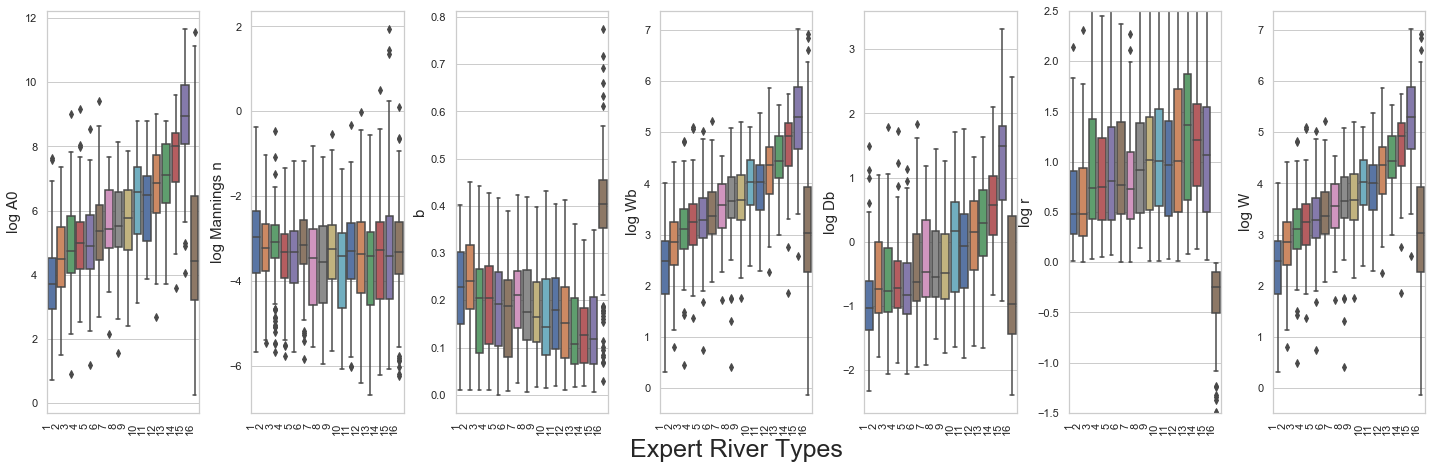

In [649]:
pca_df['logchan_width'] = np.log(pca_df['chan_width']) #mean at-a-station width

fig, axs = plt.subplots(ncols=7, figsize=(20, 7))
sns.boxplot(x="clusterGeomorphIndex", y='logA0', data=pca_df, palette='deep', ax=axs[0], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logn', data=pca_df, palette='deep', ax=axs[1], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='b', data=pca_df, palette='deep', ax=axs[2], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logWb', data=pca_df, palette='deep', ax=axs[3], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logDb', data=pca_df, palette='deep', ax=axs[4], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logr', data=pca_df, palette='deep', ax=axs[5], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logchan_width', data=pca_df, palette='deep', ax=axs[6], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])

fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

axs[0].set_ylabel('log A0', fontsize=15)
axs[1].set_ylabel('log Mannings n', fontsize=15)
axs[2].set_ylabel('b', fontsize=15)
axs[3].set_ylabel('log Wb', fontsize=15)
axs[4].set_ylabel('log Db', fontsize=15)
axs[5].set_ylabel('log r', fontsize=15)
axs[6].set_ylabel('log W', fontsize=15)

axs[5].set_ylim(-1.5,2.5)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('Expert River Types', fontsize=25)
axs[4].set_xlabel('')
axs[5].set_xlabel('')
axs[6].set_xlabel('')

fig.savefig('expert_priors.tif')

In [650]:
pca_df.to_csv('cross_sections_rep_hydraulics.csv')

In [184]:
#maps class to river based on 'closest' median cross-sectional average width of each class
binnedMeanWdths = pca_df.groupby('clusterGeomorphIndex')['logchan_width'].describe()
binnedMeanWdths.to_csv('WidthsClass_geoBAMexpert.csv')

#save prior distribution parameters
priorWbClass = pca_df.groupby('clusterGeomorphIndex')['logWb'].describe()
priorDbClass = pca_df.groupby('clusterGeomorphIndex')['logDb'].describe()
prior_rClass = pca_df.groupby('clusterGeomorphIndex')['logr'].describe()
priorA0Class = pca_df.groupby('clusterGeomorphIndex')['logA0'].describe()
priorNClass = pca_df.groupby('clusterGeomorphIndex')['logn'].describe()
priorBClass = pca_df.groupby('clusterGeomorphIndex')['b'].describe()

priorWbClass.to_csv('priorsWb_geoBAMexpert.csv')
priorDbClass.to_csv('priorsDb_geoBAMexpert.csv')
prior_rClass.to_csv('priorsR_geoBAMexpert.csv')
priorA0Class.to_csv('priorsA0_geoBAMexpert.csv')
priorNClass.to_csv('priorsN_geoBAMexpert.csv')
priorBClass.to_csv('priorsB_geoBAMexpert.csv')

<h2> <font color=darkolivegreen>Unsupervised Classification </font></h2>

<h4> <font color=darkolivegreen> DBSCAN </font></h4>

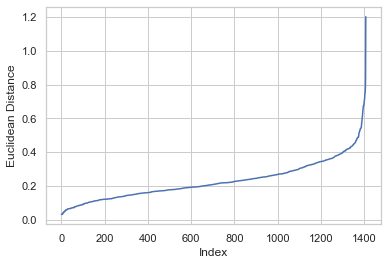

In [660]:
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.neighbors import NearestNeighbors
sns.set_style("whitegrid")

features = dbscan_df[['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 
            'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA', 'sinuosity', 'velocity_var',
            'depth_var','width_var', 'n_var','unitPower_var','Fb_var','shearStress_var', 'minEntrain_var']]

# Scaling the data to bring all the attributes to a comparable level 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(features) 
  
# Normalizing the data so that the data 
# approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 
  
# Renaming the columns 
X_normalized.columns = features.columns 

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_normalized)
distances, indices = nbrs.kneighbors(X_normalized)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig = plt.figure()
plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('Euclidean Distance')

fig.savefig('optimal_eps.tif')

This is a plot of distance to n-nearest neighbors for the 1,409 points in the feature space.  Optimal epsilon occurs at the point of steepest curve.  This is approximately 0.5

In [661]:
#run DBSCAN
# Numpy array of all the cluster labels assigned to each data point 
db_default = DBSCAN(eps = 0.5, min_samples = 5).fit(X_normalized)
labels = db_default.labels_ 

In [662]:
from sklearn import metrics

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

dbscan_df['cluster'] = labels
dbscan_df['logchan_width'] = np.log(dbscan_df['chan_width'])
dbscan_df.groupby('cluster')['logr'].describe()

Estimated number of clusters: 7
Estimated number of noise points: 66


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,66.0,1.345937,1.555221,-1.487340,0.288274,0.952936,1.942648,8.037716
0,1224.0,0.802291,0.796842,-1.694463,0.261844,0.722592,1.277469,3.885279
1,23.0,0.816353,1.174460,-2.580471,0.120861,0.977709,1.503274,2.701881
2,11.0,1.095509,0.856221,-0.188149,0.469456,1.230107,1.621517,2.468098
3,25.0,0.073789,1.205119,-2.297051,-0.684620,0.303822,0.717793,2.311889
4,6.0,0.770965,0.744723,-0.374243,0.398933,0.917785,1.100232,1.777431
5,22.0,0.512587,0.955376,-0.636078,-0.124799,0.141432,0.869035,2.674956
6,32.0,-0.163838,0.429378,-0.827781,-0.400638,-0.248390,0.067465,0.991361


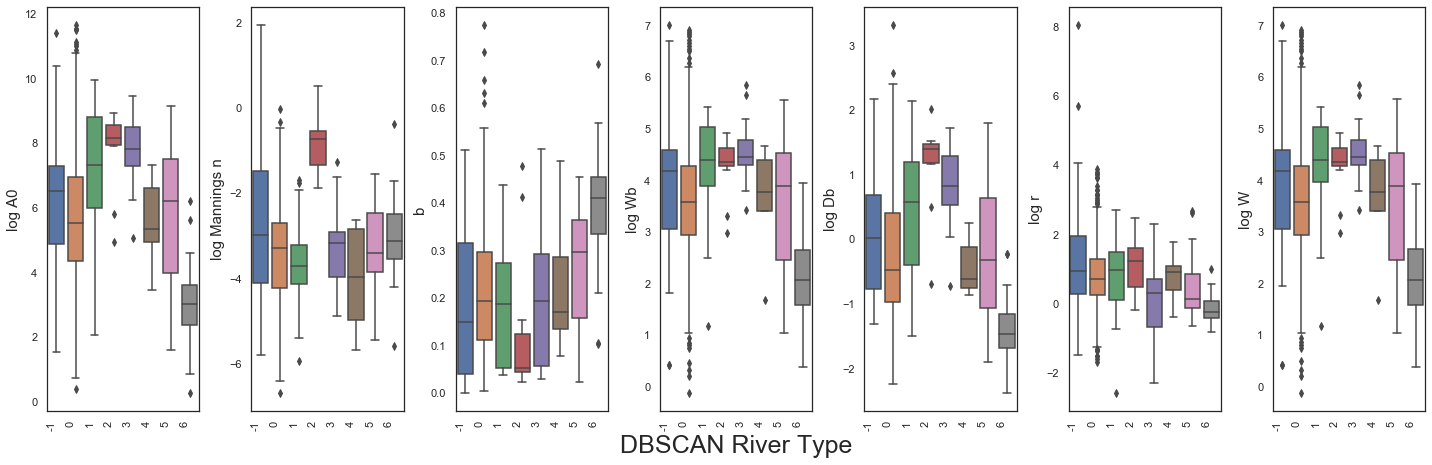

In [639]:
sns.set_style("white")

fig, axs = plt.subplots(ncols=7, figsize=(20, 7))
sns.boxplot(x="cluster", y='logA0', data=dbscan_df, palette='deep', ax=axs[0])
sns.boxplot(x="cluster", y='logn', data=dbscan_df, palette='deep', ax=axs[1])
sns.boxplot(x="cluster", y='b', data=dbscan_df, palette='deep', ax=axs[2])
sns.boxplot(x="cluster", y='logWb', data=dbscan_df, palette='deep', ax=axs[3])
sns.boxplot(x="cluster", y='logDb', data=dbscan_df, palette='deep', ax=axs[4])
sns.boxplot(x="cluster", y='logr', data=dbscan_df, palette='deep', ax=axs[5])
sns.boxplot(x="cluster", y='logchan_width', data=dbscan_df, palette='deep', ax=axs[6])

fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

axs[0].set_ylabel('log A0', fontsize=15)
axs[1].set_ylabel('log Mannings n', fontsize=15)
axs[2].set_ylabel('b', fontsize=15)
axs[3].set_ylabel('log Wb', fontsize=15)
axs[4].set_ylabel('log Db', fontsize=15)
axs[5].set_ylabel('log r', fontsize=15)
axs[6].set_ylabel('log W', fontsize=15)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('DBSCAN River Type', fontsize=25)
axs[4].set_xlabel('')
axs[5].set_xlabel('')
axs[6].set_xlabel('')

#fig.savefig('dbscan_priors.tif')

In [594]:
#save prior distribution parameters
priorWbClass = dbscan_df.groupby('cluster')['logWb'].describe()
priorDbClass = dbscan_df.groupby('cluster')['logDb'].describe()
prior_rClass = dbscan_df.groupby('cluster')['logr'].describe()
priorA0Class = dbscan_df.groupby('cluster')['logA0'].describe()
priorNClass = dbscan_df.groupby('cluster')['logn'].describe()
priorBClass = dbscan_df.groupby('cluster')['b'].describe()

priorWbClass.to_csv('priorsWb_geoBAMunsupervised.csv')
priorDbClass.to_csv('priorsDb_geoBAMunsupervised.csv')
prior_rClass.to_csv('priorsR_geoBAMunsupervised.csv')
priorA0Class.to_csv('priorsA0_geoBAMunsupervised.csv')
priorNClass.to_csv('priorsN_geoBAMunsupervised.csv')
priorBClass.to_csv('priorsB_geoBAMunsupervised.csv')

<h4> <font color=darkolivegreen> Predictive model for unsupervised classes </font></h4>

In [667]:
X_test

,chan_width
site_no,
2350512.0,92.720
6818000.0,236.680
11351948.0,72.590
2335000.0,60.695
9070500.0,51.240
...,...
6023500.0,7.930
3403500.0,42.700
208521324.0,15.555


In [670]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#dbscan_df['width_sd'] = np.sqrt(dbscan_df['width_var'])

#temp = data.drop_duplicates('site_no')
X = dbscan_df[['chan_width']]
y = dbscan_df['cluster']

#Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=70)

#'One-vs-rest ogistic' regression used so I can manually implement the model in geoBAM
clf = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)
# Train model
model = clf.fit(X, y)

model.predict(X_test)
model.score(X_test, y_test) #87% accuracy
model.coef_
model.intercept_

C:\Users\cbrinkerhoff\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\cbrinkerhoff\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([-3.11056777,  1.95763357, -4.05274822, -4.43158034, -3.99272449,
       -4.28204232, -3.87408245, -1.16209678])

In [591]:
predict = model.predict_proba(X_test)


predict = np.argmax(predict, axis=1)
predict = predict - 1

from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict)

0.8652482269503546